## Dataset

In [2]:
import gdown
file_id = "1cPmNRjDZDevMK5vzXK7M12kwhFfpcjsb"
gdown.download(f"https://drive.google.com/uc?id={file_id}", output="TCGA_BRCA_RNA.h5ad", quiet=False)


# https://drive.google.com/file/d/1roKItvj-FOjnGBQsert9ANMI8mbDeBwn/view?usp=sharing
file_id = "1roKItvj-FOjnGBQsert9ANMI8mbDeBwn"
gdown.download(f"https://drive.google.com/uc?id={file_id}", output="TCGA_BRCA_RNA_HiSeqV2.h5ad", quiet=False)


!pip install scanpy
# !pip install tabpfn

Downloading...
From (original): https://drive.google.com/uc?id=1cPmNRjDZDevMK5vzXK7M12kwhFfpcjsb
From (redirected): https://drive.google.com/uc?id=1cPmNRjDZDevMK5vzXK7M12kwhFfpcjsb&confirm=t&uuid=04624bbf-8831-46ed-a7ac-b42460c5e8a2
To: /content/TCGA_BRCA_RNA.h5ad
100%|██████████| 575M/575M [00:11<00:00, 50.6MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1roKItvj-FOjnGBQsert9ANMI8mbDeBwn
From (redirected): https://drive.google.com/uc?id=1roKItvj-FOjnGBQsert9ANMI8mbDeBwn&confirm=t&uuid=d570343e-5b30-488c-b02e-948a417d6564
To: /content/TCGA_BRCA_RNA_HiSeqV2.h5ad
100%|██████████| 218M/218M [00:01<00:00, 110MB/s]


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 67.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.9/169.9 kB 22.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.2/58.2 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.0/261.0 kB 29.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 115.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.5/53.5 kB 5.4 MB/s eta 0:00:00


In [3]:
import numpy as np
import os

# # ========== 配置 ==========
# H5AD_PATH = "/content/TCGA_BRCA_RNA.h5ad"
# H5AD_PATH = "/content/TCGA_BRCA_RNA_HiSeqV2.h5ad"

# ========= Step 0: 固定随机种子 ==========
SEED = 42
np.random.seed(SEED)
import random
random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

os.environ["SCIPY_ARRAY_API"] = "1"


## Lightgbm

In [5]:
import os
import random
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad
import warnings
import lightgbm as lgb
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, f1_score
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils import shuffle

from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE

# ========= Step 0: 固定随机种子 ==========
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

# ========= Step 1: 读取 h5ad ==========

H5AD_PATH = "/content/TCGA_BRCA_RNA.h5ad"
adata = sc.read_h5ad(H5AD_PATH)
adata.var_names_make_unique()
adata = adata[adata.obs["stage"].astype(str) != "Unknown"].copy()


# ========= Step 2: 标签处理 ==========
labels = adata.obs["stage"].astype(str)
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(labels)
# X = adata.X
from scipy.sparse import issparse
if issparse(adata.X):
    X = adata.X.toarray()
else:
    X = adata.X

class_names = label_encoder.classes_
stage_iv_index = label_encoder.transform(['Stage IV'])[0]

# ========= Step 3: 划分训练集和测试集 ==========
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=SEED
)

# ========= Step 4: SMOTE 数据增强 ==========
sm = SMOTE(random_state=SEED)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

# ========= Step 5: 手动复制 Stage IV 样本 ==========
iv_mask = y_train_res == stage_iv_index
X_iv = X_train_res[iv_mask]
y_iv = y_train_res[iv_mask]

N = 3  # 复制次数
X_train_res = np.vstack([X_train_res] + [X_iv] * N)
y_train_res = np.concatenate([y_train_res] + [y_iv] * N)

# ========= Step 6: 特征选择 ==========
selector = SelectKBest(score_func=mutual_info_classif, k=500)
X_train_sel = selector.fit_transform(X_train_res, y_train_res)
X_test_sel = selector.transform(X_test)

# ========= Step 7: 权重设置 ==========
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y_train_res), y=y_train_res)
class_weights[stage_iv_index] *= 10  # 强化 Stage IV
class_weight_dict = dict(enumerate(class_weights))

# 可选 sample_weight（可注释）
sample_weight = np.ones(len(y_train_res))
sample_weight[y_train_res == stage_iv_index] *= 5

# ========= Step 8: LightGBM 训练 ==========
lgbm = LGBMClassifier(
    objective="multiclass",
    num_class=len(class_names),
    class_weight=class_weight_dict,
    learning_rate=0.01,
    n_estimators=1000,
    min_data_in_leaf=50,
    min_child_weight=10,
    max_depth=4,
    num_leaves=7,
    reg_alpha=1.0,
    reg_lambda=1.0,
    subsample=0.8,
    colsample_bytree=0.8,
    feature_fraction=0.8,
    bagging_fraction=0.8,
    bagging_freq=1,
    boosting_type="gbdt",
    random_state=SEED,
    deterministic=True,
    n_jobs=1
)

lgbm.fit(
    X_train_sel, y_train_res,
    sample_weight=sample_weight,
    eval_set=[(X_test_sel, y_test)],
    eval_metric="multi_logloss",
    callbacks=[lgb.early_stopping(stopping_rounds=50)]
)


[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=0.8 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.8 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=0.8 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.8 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Info] Auto-choosing col-wise multi-threading, 

LGBMClassifier(bagging_fraction=0.8, bagging_freq=1,
               class_weight={0: np.float64(1.75), 1: np.float64(1.75),
                             2: np.float64(1.75), 3: np.float64(4.375)},
               colsample_bytree=0.8, deterministic=True, feature_fraction=0.8,
               learning_rate=0.01, max_depth=4, min_child_weight=10,
               min_data_in_leaf=50, n_estimators=1000, n_jobs=1, num_class=4,
               num_leaves=7, objective='multiclass', random_state=42,
               reg_alpha=1.0, reg_lambda=1.0, subsample=0.8)

In [7]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# ========= Step 9: Soft Labeling 阈值调整 ==========
y_proba = lgbm.predict_proba(X_test_sel)
# soft_threshold = 0.3
y_pred_raw = lgbm.predict(X_test_sel)
# y_pred_soft = np.copy(y_pred_raw)
# y_pred_soft[y_proba[:, stage_iv_index] > soft_threshold] = stage_iv_index

# ========= Step 10: 评估函数 ==========
from sklearn.metrics import confusion_matrix

def evaluate(pred, y_true, name):
    acc = accuracy_score(y_true, pred)
    macro_f1 = f1_score(y_true, pred, average="macro", zero_division=0)

    # macro_f1 = f1_score(y_true, pred, average="macro")
    print(f"\n LightGBM Macro F1-score: {macro_f1:.4f} ({name})")
    print(classification_report(y_true, pred, target_names=class_names, zero_division=0))

    print(f"\n Macro F1-score: {macro_f1:.4f}, Accuracy: {acc:.4f}")

    # 混淆矩阵
    cm = confusion_matrix(y_true, pred)
    print(" LightGBM Confusion Matrix:")
    print(cm)

# evaluate(lgbm.predict(X_train_sel), y_train_res, "Train")
print("LightGBM model result")
evaluate(y_pred_raw, y_test, "Test (Raw)")

# # ========= Step 11: 打印 Stage IV 概率 ==========
# print("🧪 Stage IV 预测概率（前5条）:")
# print(y_proba[:5, stage_iv_index])


from itertools import product
from sklearn.metrics import precision_recall_fscore_support

# 所有候选阈值（你可以自定义更大搜索空间）
stage_iv_range = [0.02, 0.05, 0.15, 0.20,0.45, 0.5]
stage_iii_range = [0.30, 0.35, 0.40,0.45, 0.5,0.55, 0.6]
stage_i_range   = [0.30, 0.35, 0.4, 0.5]
stage_ii_range  = [ 0.4, 0.5, 0.6, 0.7, 0.8]

results = []

class2index = {cls: i for i, cls in enumerate(class_names)}
stage_iv_idx = class2index["Stage IV"]
stage_i_idx = class2index["Stage I"]

# 遍历所有组合
for th_iv, th_iii, th_i, th_ii in product(stage_iv_range, stage_iii_range, stage_i_range, stage_ii_range):

    # 多类别 Soft Label Override
    y_pred = np.copy(y_pred_raw)
    for i in range(len(y_pred)):
        if y_proba[i][class2index["Stage IV"]] > th_iv:
            y_pred[i] = class2index["Stage IV"]
        elif y_proba[i][class2index["Stage III"]] > th_iii:
            y_pred[i] = class2index["Stage III"]
        elif y_proba[i][class2index["Stage I"]] > th_i:
            y_pred[i] = class2index["Stage I"]
        elif y_proba[i][class2index["Stage II"]] > th_ii:
            y_pred[i] = class2index["Stage II"]
        # 否则保留原始预测

    # 评估指标
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_test, y_pred, average=None, zero_division=0
    )
    macro_f1 = f1_score(y_test, y_pred, average="macro")

    results.append({
        "Stage IV Thresh": th_iv,
        "Stage III Thresh": th_iii,
        "Stage II Thresh": th_ii,
        "Stage I Thresh": th_i,
        "Macro F1": macro_f1,
        "Stage IV Recall": recall[stage_iv_idx],
        "Stage I Precision": precision[stage_i_idx],
    })

# 转成 DataFrame 排序
results_df = pd.DataFrame(results)
results_df = results_df.sort_values("Macro F1", ascending=False)

# # 显示 Top 10
# from IPython.display import display
# display(results_df.head(10))



# ===== 1. 提取最优结果 =====
best = results_df.iloc[0]
th_iv = best["Stage IV Thresh"]
th_iii = best["Stage III Thresh"]
th_ii = best["Stage II Thresh"]
th_i = best["Stage I Thresh"]

# print("Best soft threshould:")
# print(best[["Stage IV Thresh", "Stage III Thresh", "Stage II Thresh", "Stage I Thresh"]])

# ===== 2. 使用最佳阈值重新预测 =====
# y_pred_best = np.copy(y_pred_raw)
# for i in range(len(y_pred_best)):
#     if y_proba[i][class2index["Stage IV"]] > th_iv:
#         y_pred_best[i] = class2index["Stage IV"]
#     elif y_proba[i][class2index["Stage III"]] > th_iii:
#         y_pred_best[i] = class2index["Stage III"]
#     elif y_proba[i][class2index["Stage I"]] > th_i:
#         y_pred_best[i] = class2index["Stage I"]
#     elif y_proba[i][class2index["Stage II"]] > th_ii:
#         y_pred_best[i] = class2index["Stage II"]
#     # 否则保留原始预测


# # ===== 3. 打印评估指标 =====
# print("\n LightGBM Classification Report (Best Thresholds):")
# print(classification_report(y_test, y_pred_best, target_names=class_names, zero_division=0))

# macro_f1 = f1_score(y_test, y_pred_best, average="macro")
# acc = accuracy_score(y_test, y_pred_best)
# print(f" Macro F1-score: {macro_f1:.4f}, Accuracy: {acc:.4f}")

# # ===== 4. 混淆矩阵可视化 =====
# cm = confusion_matrix(y_test, y_pred_best)
# df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
# print(" LightGBM Confusion Matrix:")
# print(df_cm)



# ===== 使用最佳阈值做 Dynamic Override 预测 =====
y_pred_best = []
for i in range(len(y_proba)):
    candidate_classes = []

    for cls in class2index:
        class_idx = class2index[cls]
        prob = y_proba[i][class_idx]
        thresh = best[f"{cls} Thresh"]
        if prob > thresh:
            candidate_classes.append((cls, prob))

    if candidate_classes:
        # 选择超过阈值中 softmax 概率最大的类别
        selected_cls = max(candidate_classes, key=lambda x: x[1])[0]
        y_pred_best.append(class2index[selected_cls])
    else:
        # fallback: 使用原始预测
        y_pred_best.append(y_pred_raw[i])

# 打印评估指标
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score

print("\nLightGBM Classification Report (Best Soft Thresholds):")
print(classification_report(y_test, y_pred_best, target_names=class_names, zero_division=0))

macro_f1 = f1_score(y_test, y_pred_best, average="macro")
acc = accuracy_score(y_test, y_pred_best)
print(f"Macro F1-score: {macro_f1:.4f}, Accuracy: {acc:.4f}")

# 混淆矩阵
cm = confusion_matrix(y_test, y_pred_best)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
print("LightGBM Confusion Matrix(Best Soft Thresholds):")
print(df_cm)



[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=0.8 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.8 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=0.8 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.8 will be ignored. Current value: bagging_fraction=0.8
LightGBM model result

 LightGBM Macro F1-score: 0.3823 (T

## MLP

In [8]:
import os
import random
import numpy as np
import pandas as pd
import scanpy as sc
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

# ===== 固定随机种子 =====
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)

# ===== 参数 =====
BATCH_SIZE = 16
LR = 1e-3
NUM_EPOCHS = 20
HIDDEN1 = 1024
HIDDEN2 = 256
DROPOUT_RATE = 0.5
MODEL_SAVE_PATH = "./mlp_best.pt"

# ===== 读取数据 =====
# H5AD_PATH = "/content/TCGA_BRCA_RNA.h5ad"
H5AD_PATH = "/content/TCGA_BRCA_RNA_HiSeqV2.h5ad"
adata = sc.read_h5ad(H5AD_PATH)
adata.var_names_make_unique()

# ===== 只保留合法标签 =====
valid_stages = ["Stage I", "Stage II", "Stage III", "Stage IV"]
adata = adata[adata.obs["stage"].isin(valid_stages)].copy()

# ===== 特征矩阵 & 标签 =====
import scipy.sparse
X = adata.X.toarray() if scipy.sparse.issparse(adata.X) else np.array(adata.X)
labels = adata.obs["stage"].astype(str).values
le = LabelEncoder()
y = le.fit_transform(labels)  # 0~3

INPUT_DIM = X.shape[1]
NUM_CLASSES = len(le.classes_)
print("X shape:", X.shape)
print("Classes:", le.classes_)

# ===== 划分训练 / 测试集 =====
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=SEED
)

# ===== 类别权重 =====
class_weights = compute_class_weight("balanced", classes=np.unique(y_train), y=y_train)
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(DEVICE)
print("Class weights:", class_weights.cpu().numpy())

# ===== 自定义 Dataset =====
class RNAStageDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)
    def __len__(self): return len(self.y)
    def __getitem__(self, idx): return self.X[idx], self.y[idx]

train_loader = DataLoader(RNAStageDataset(X_train, y_train), batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(RNAStageDataset(X_test, y_test), batch_size=BATCH_SIZE, shuffle=False)

# ===== 定义 MLP 模型 =====
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, hidden1, hidden2, num_classes, dropout_rate=0.5):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden1)
        self.bn1 = nn.BatchNorm1d(hidden1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(hidden1, hidden2)
        self.bn2 = nn.BatchNorm1d(hidden2)
        self.out = nn.Linear(hidden2, num_classes)
    def forward(self, x):
        x = self.fc1(x); x = self.bn1(x); x = self.relu(x); x = self.dropout(x)
        x = self.fc2(x); x = self.bn2(x); x = self.relu(x); x = self.dropout(x)
        return self.out(x)

model = MLPClassifier(INPUT_DIM, HIDDEN1, HIDDEN2, NUM_CLASSES, DROPOUT_RATE).to(DEVICE)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=1e-4)

# ===== 训练循环 =====
best_f1 = 0.0
for epoch in range(1, NUM_EPOCHS + 1):
    model.train(); total_loss = 0.0
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(DEVICE), batch_y.to(DEVICE)
        optimizer.zero_grad()
        logits = model(batch_X)
        loss = criterion(logits, batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * batch_X.size(0)
    avg_loss = total_loss / len(train_loader.dataset)

    # ===== 验证阶段 =====
    model.eval(); preds, truths = [], []
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            batch_X = batch_X.to(DEVICE)
            logits = model(batch_X)
            preds_batch = torch.argmax(logits, dim=1).cpu().numpy()
            preds.extend(preds_batch)
            truths.extend(batch_y.numpy())

    acc = accuracy_score(truths, preds)
    f1 = f1_score(truths, preds, average="macro", zero_division=0)
    print(f"Epoch {epoch}/{NUM_EPOCHS} - Loss: {avg_loss:.4f} | Acc: {acc:.4f} | Macro F1: {f1:.4f}")

    if f1 > best_f1:
        best_f1 = f1
        torch.save(model.state_dict(), MODEL_SAVE_PATH)
        print("✅ New best model saved!")


Using device: cuda
X shape: (1216, 17170)
Classes: ['Stage I' 'Stage II' 'Stage III' 'Stage IV']
Class weights: [1.5283018  0.43862817 1.0995475  6.394737  ]
Epoch 1/20 - Loss: 1.5409 | Acc: 0.3607 | Macro F1: 0.2438
✅ New best model saved!
Epoch 2/20 - Loss: 1.3647 | Acc: 0.4016 | Macro F1: 0.2717
✅ New best model saved!
Epoch 3/20 - Loss: 1.2299 | Acc: 0.3607 | Macro F1: 0.2618
Epoch 4/20 - Loss: 1.0772 | Acc: 0.3279 | Macro F1: 0.2457
Epoch 5/20 - Loss: 0.9521 | Acc: 0.2541 | Macro F1: 0.2252
Epoch 6/20 - Loss: 0.7901 | Acc: 0.3689 | Macro F1: 0.2181
Epoch 7/20 - Loss: 0.7031 | Acc: 0.5697 | Macro F1: 0.2406
Epoch 8/20 - Loss: 0.6448 | Acc: 0.1967 | Macro F1: 0.1288
Epoch 9/20 - Loss: 0.6144 | Acc: 0.2418 | Macro F1: 0.1708
Epoch 10/20 - Loss: 0.4855 | Acc: 0.2377 | Macro F1: 0.2271
Epoch 11/20 - Loss: 0.4846 | Acc: 0.5697 | Macro F1: 0.2476
Epoch 12/20 - Loss: 0.4077 | Acc: 0.2869 | Macro F1: 0.1981
Epoch 13/20 - Loss: 0.4071 | Acc: 0.2787 | Macro F1: 0.2359
Epoch 14/20 - Loss: 0.3

MLP model result

[Raw Prediction] Test Results:
Classification Report:
              precision    recall  f1-score   support

     Stage I       0.27      0.28      0.27        40
    Stage II       0.65      0.68      0.66       139
   Stage III       0.40      0.36      0.38        55
    Stage IV       0.12      0.10      0.11        10

    accuracy                           0.52       244
   macro avg       0.36      0.35      0.36       244
weighted avg       0.51      0.52      0.51       244

Macro F1-score: 0.3564, Accuracy: 0.5164
Confusion Matrix:
[[11 22  7  0]
 [23 94 20  2]
 [ 7 23 20  5]
 [ 0  6  3  1]]
Classification Report:
              precision    recall  f1-score   support

     Stage I       0.30      0.28      0.29        40
    Stage II       0.67      0.68      0.67       139
   Stage III       0.43      0.36      0.40        55
    Stage IV       0.15      0.30      0.20        10

    accuracy                           0.52       244
   macro avg       0.39 

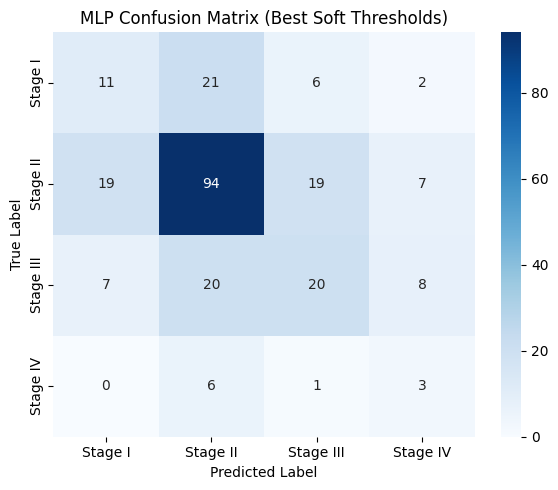

In [13]:
print("MLP model result")
# ====== ✅ 测试阶段：Raw + Soft Threshold ======
model.load_state_dict(torch.load(MODEL_SAVE_PATH))
model.eval()

soft_preds, raw_preds, truths = [], [], []
proba_all = []

with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X = batch_X.to(DEVICE)
        logits = model(batch_X)
        probs = torch.softmax(logits, dim=1).cpu().numpy()
        preds = np.argmax(probs, axis=1)

        raw_preds.extend(preds)
        truths.extend(batch_y.numpy())
        proba_all.extend(probs)

# numpy 化
y_test = np.array(truths)
y_pred_raw = np.array(raw_preds)
y_proba = np.array(proba_all)

# ========= 原始预测评估 =========
print("\n[Raw Prediction] Test Results:")


print("Classification Report:")
print(classification_report(y_test, y_pred_raw, target_names=le.classes_, zero_division=0))

# print("Accuracy:", accuracy_score(y_test, y_pred_raw))
macro_f1 = f1_score(y_test, y_pred_raw, average="macro")
acc = accuracy_score(y_test, y_pred_raw)
print(f"Macro F1-score: {macro_f1:.4f}, Accuracy: {acc:.4f}")


print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_raw))


# ========= soft threshold 搜索 + 最优组合预测 =========
from itertools import product
from sklearn.metrics import precision_recall_fscore_support

stage_i_range   = [0.2, 0.3, 0.4, 0.5]
stage_ii_range  = [0.4, 0.5, 0.6, 0.7]
stage_iii_range = [0.2, 0.3, 0.4, 0.5]
stage_iv_range  = [0.1, 0.15, 0.2, 0.25, 0.3, 0.4]

results = []
class2index = {cls: i for i, cls in enumerate(le.classes_)}
stage_iv_idx = class2index["Stage IV"]
stage_i_idx = class2index["Stage I"]

for th_i, th_ii, th_iii, th_iv in product(stage_i_range, stage_ii_range, stage_iii_range, stage_iv_range):
    thresholds = {
        "Stage I": th_i,
        "Stage II": th_ii,
        "Stage III": th_iii,
        "Stage IV": th_iv
    }

    y_pred = np.copy(y_pred_raw)
    for i in range(len(y_pred)):
        if y_proba[i][class2index["Stage IV"]] > thresholds["Stage IV"]:
            y_pred[i] = class2index["Stage IV"]
        elif y_proba[i][class2index["Stage III"]] > thresholds["Stage III"]:
            y_pred[i] = class2index["Stage III"]
        elif y_proba[i][class2index["Stage I"]] > thresholds["Stage I"]:
            y_pred[i] = class2index["Stage I"]
        elif y_proba[i][class2index["Stage II"]] > thresholds["Stage II"]:
            y_pred[i] = class2index["Stage II"]

    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average=None, zero_division=0)
    macro_f1 = f1_score(y_test, y_pred, average="macro")

    results.append({
        "Stage I Thresh": th_i,
        "Stage II Thresh": th_ii,
        "Stage III Thresh": th_iii,
        "Stage IV Thresh": th_iv,
        "Macro F1": macro_f1,
        "Stage IV Recall": recall[stage_iv_idx],
        "Stage I Precision": precision[stage_i_idx],
        "accuracy": accuracy_score(y_test, y_pred),
        "y_pred": y_pred
    })

# ========= 结果展示 =========
results_df = pd.DataFrame(results).sort_values("Macro F1", ascending=False)

# # 展示前10
# from IPython.display import display
# display(results_df.head(10))

# ========= 使用最佳组合评估 =========
best_result = results_df.iloc[0]
best_pred = best_result["y_pred"]

print("Classification Report:")
print(classification_report(y_test, best_pred, target_names=le.classes_, zero_division=0))

# print("Accuracy:", accuracy_score(y_test, best_pred))
macro_f1 = f1_score(y_test, best_pred, average="macro")
acc = accuracy_score(y_test, best_pred)
print(f"Macro F1-score: {macro_f1:.4f}, Accuracy: {acc:.4f}")

print("Confusion Matrix:")
print(confusion_matrix(y_test, best_pred))

# ========= 可视化混淆矩阵 =========
import seaborn as sns
import matplotlib.pyplot as plt
cm = confusion_matrix(y_test, best_pred)
df_cm = pd.DataFrame(cm, index=le.classes_, columns=le.classes_)

plt.figure(figsize=(6, 5))
sns.heatmap(df_cm, annot=True, fmt="d", cmap="Blues")
plt.title("MLP Confusion Matrix (Best Soft Thresholds)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()